# Derived indices for model predictors

Along with some base variables processed in `2_hourly_to_daily.ipynb` (https://are.nci.org.au/node/gadi-cpu-bdw-0054.gadi.nci.org.au/45142/lab/tree/g/data/w42/dr6273/work/demand_model/2_hourly_to_daily.ipynb), here we compute additional predictors that use those variables.

What climate metrics might affect energy demand?

Bloomfield et al (2019) https://rmets.onlinelibrary.wiley.com/doi/10.1002/met.1858 :
- Heating Degree Days (based on daily mean T) - Done
- Cooling Degree Days (based on daily mean T) - Done

van der Wiel et al (2019) https://www.sciencedirect.com/science/article/pii/S1364032119302862#sec3 :
- Daily mean temperature (two linear regimes combined) - Done.

Kang & Reiner (2022) https://www.sciencedirect.com/science/article/pii/S014098832200189X :
- This study is from Ireland
- Number of sun hours - radiation as proxy, Done
- Wind speed - Done
- humidity - Done
- Rainfall - Done

Me spitballing:
- Maximum daily T - Done
- Minimum daily T - Done
- Humidity (daily average and/or overnight?) - daily avg only Done
- Heatwaves (e.g. EHF or even just 3-day T?)

Also useful read: https://www.energycouncil.com.au/media/mejc2mfz/extreme-weather-and-electricity-supply.pdf
- Heatwaves in multiple states (might not affect demand though, just ability to supply)
- Demand peaks in 3rd and 4th day of a heatwave (so 4-day T?)
- Cloud cover (affects demand on grid by reducing rooftop solar's ability to smooth the peaks) - radiation as proxy, Done

Could also consider:
- weighting the selected metrics by population (we eventually want state and national figures)
- Detrending everything, including demand.

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

import bottleneck

In [67]:
client.close()
cluster.close()

In [68]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "04:00:00"
cores = 24
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                                          
                     job_extra_directives=["-q normal",
                                           "-P w42",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/w42+gdata/rt52"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43455 instead
  warnings.warn(


In [69]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/36097/status,
Dashboard: /proxy/36097/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.38:37249,Workers: 0
Dashboard: /proxy/36097/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
import xarray as xr
import numpy as np

In [6]:
%cd /g/data/w42/dr6273/work/demand_model//

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [7]:
era_path = "/g/data/w42/dr6273/work/data/era5/"

In [8]:
years = range(1959, 2023)

# We need to detrend temperature first

Need to do some intermediate steps as this is a big operation.

1. Open daily netcdf files, then write to zarr with a single time chunk
2. Open this zarr store and detrend, then write to a new zarr store

In [101]:
# Need to chunk when we open these files!
T = xr.open_mfdataset(era_path+"2t/daily/*.nc", chunks={"time": 50, "latitude": 200, "longitude": 500})

In [102]:
T = T - 273.15

In [103]:
T.nbytes / 1024 ** 3

90.41259867325425

In [34]:
T.to_zarr(
    "/scratch/w42/dr6273/tmp/2t_era5_daily_1959-2022.zarr",
    mode="w",
    consolidated=True
)

## Let's try processing a subregion at a time, and appending

In [70]:
T = xr.open_zarr(
    "/scratch/w42/dr6273/tmp/2t_era5_daily_1959-2022.zarr",
    consolidated=True,
)

In [ ]:
for i in range(len(T["latitude"].values)):
    lat = T["latitude"].values[i]
    T_ = T.isel(latitude=i)
    
    # detrended = data - fit + mean
    Tmean = T_["t2m"].mean("time")
    Tfit = fn.detrend_dim(T_["t2m"], "time")
    Tdt = Tfit + Tmean
    
    Tdt = Tdt.to_dataset(name="t2m")
    Tdt = Tdt.expand_dims({"latitude": [lat]})
    Tdt = Tdt.chunk({"time": -1, "longitude": -1})
    
    if i == 0:
        Tdt.to_zarr(
            "/scratch/w42/dr6273/tmp/2t_detrended_era5_daily_1959-2022_by_lat.zarr",
            mode="w",
            consolidated=True
        )
    else:
        Tdt.to_zarr(
            "/scratch/w42/dr6273/tmp/2t_detrended_era5_daily_1959-2022_by_lat.zarr",
            mode="a",
            append_dim="latitude",
            consolidated=True
        )

In [59]:
test = xr.open_zarr(
            "/scratch/w42/dr6273/tmp/2t_detrended_era5_daily_1959-2022_by_lat.zarr",
            consolidated=True
        )

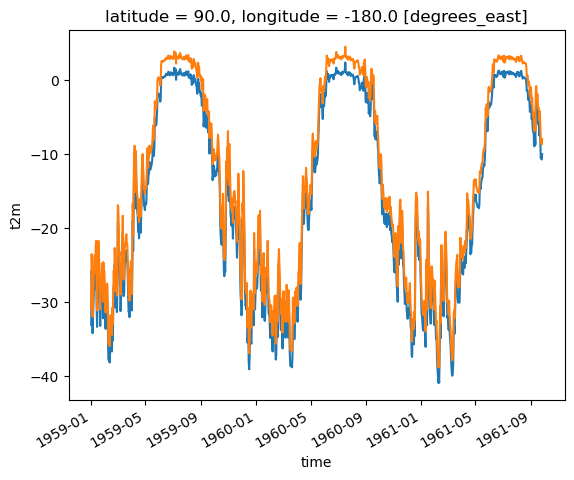

In [66]:
T.isel(latitude=0, longitude=0, time=range(1000)).t2m.plot()
test.isel(latitude=0, longitude=0, time=range(1000)).t2m.plot()

# Cooling degree day

Difference between daily average temperature and a comfort-level temperature of 24 degrees C, if the daily average temperature is above 24C.

http://www.bom.gov.au/climate/maps/averages/degree-days/#:~:text=The%20heating%20degree%20days%20or,24%20degrees%20Celsius%20for%20cooling.

In [21]:
def calc_cdd(T, comfort=24):
    """
    Cooling Degree Day.
    
    T: array of daily average temperature in degrees Celsius.
    """
    return (T - comfort).where(T > comfort, 0)

In [22]:
cdd = calc_cdd(Tdt)

In [23]:
cdd = cdd.rename({"t2m": "cdd"})

In [24]:
# Need to chunk again so that we have uniform chunk sizes
cdd = cdd.chunk({"time": "200MB"})

In [25]:
cdd.to_zarr(
    era_path + "/derived/cdd_24_era5_daily_1959-2022.zarr",
    mode="w",
    consolidated=True
)

KilledWorker: Attempted to run task ('array-8ea378c79563e7a40198e020e5ba425c', 0, 0) on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://10.6.77.33:35419. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

# Heating degree day

Difference between daily average temperature and a comfort-level temperature of 18 degrees C, if the daily average temperature is below 24C.

http://www.bom.gov.au/climate/maps/averages/degree-days/#:~:text=The%20heating%20degree%20days%20or,24%20degrees%20Celsius%20for%20cooling.

In [14]:
def calc_hdd(T, comfort=18):
    """
    Heating Degree Day.
    
    T: array of daily average temperature in degrees Celsius.
    """
    return (comfort - T).where(T < comfort, 0)

In [15]:
hdd = calc_hdd(Tdt)

In [16]:
hdd = hdd.rename({"t2m": "hdd"})

In [18]:
cdd["cdd"].where(cdd["cdd"] == 0).count().values

array(18809831208)

In [19]:
hdd["hdd"].where(hdd["hdd"] == 0).count().values

array(8860016547)

In [59]:
# Need to chunk again so that we have uniform chunk sizes
hdd = hdd.chunk({"time": "200MB"})

In [60]:
hdd.to_zarr(
    era_path + "derived/hdd_18_era5_daily_1959-2022.zarr",
    mode="w",
    consolidated=True
)

# 3- and 4-day rolling CDD, HDD and T

### AUS ONLY!

I can't figure out how to apply `rolling` operations on global data without killing workers, so let's do it by region for now.

In [17]:
def region_roll_and_write(ds, region_coords, da_name, k):
    """
    Compute rolling mean of a region subset of ds and write to zarr store.
    
    ds: dataset to process
    region_coords: dict, with 'name': str,'latitude': slice and 'longitude'" slice
    da_name: str, first part of zarr store name to read
             i.e. <da_name>_era5_daily_1959-2022.zarr
    k: int, window length for rolling
    """
    ds = ds.sel({
        "longitude": region_coords["longitude"],
        "latitude": region_coords["latitude"]
    })
    ds_roll = ds.rolling(time=k).mean()
    ds_roll = ds_roll.chunk({"time": "200MB"})
    ds_roll.to_zarr(
        era_path + "derived/"+da_name+"_"+region_coords["name"]+"_rollmean"+str(k)+"_era5_daily_1959-2022.zarr",
        mode="w",
        consolidated=True
    )

In [15]:
aus_coords = {
    "name": "Aus",
    "longitude": slice(110, 155),
    "latitude": slice(-10, -45)
}

HDD and CDD

In [16]:
for name in ["hdd_18", "cdd_24"]:
    for k in [3, 4]:
        ds = xr.open_zarr(
            era_path + "derived/"+name+"_era5_daily_1959-2022.zarr",
            consolidated=True
        )
        region_roll_and_write(ds, aus_coords, name, k)

Temperature

In [18]:
for k in [3, 4]:
    ds = xr.open_mfdataset(era_path+"2t/daily/*.nc", chunks={"time": "200MB"})
    region_roll_and_write(ds, aus_coords, "2t", k)

# Close cluster

In [24]:
client.close()
cluster.close()